**Phase boundary recognition**

We will now apply the trained multiheaded network and apply it to the phase diagram.

First, the data points generated for different DMI strength and magnetic field strength are read in and concatenated.

In [1]:
import numpy as np
import pandas as pd
import os

#The data is stored here. We will use a list to store all the relavant PhaseDiagram csv files.
filepath = "/users/PAS1495/gsdbuilder/6820BigData/bigdata_6820-JasonGuo0/ProjectData/Summary/Dataset/"
Phases = []
for roots, dirs, files in os.walk(filepath):
    for file_ in files:
        if file_.endswith('.csv') and file_.startswith('PhaseDiagram'):
            print(filepath + file_ +" added")
            Phases.append(filepath + file_)

#Concatenate all the csv files.
phase_diagram = pd.DataFrame()
for i in range(len(Phases)):
    phase_diagram = pd.concat([phase_diagram, pd.read_csv(Phases[i])])
    
print("The size of our phase diagram: ", len(phase_diagram))

/users/PAS1495/gsdbuilder/6820BigData/bigdata_6820-JasonGuo0/ProjectData/Summary/Dataset/PhaseDiagramD0_0~0_0.csv added
/users/PAS1495/gsdbuilder/6820BigData/bigdata_6820-JasonGuo0/ProjectData/Summary/Dataset/PhaseDiagramD0_1~0_1.csv added
/users/PAS1495/gsdbuilder/6820BigData/bigdata_6820-JasonGuo0/ProjectData/Summary/Dataset/PhaseDiagramD0_2~0_2.csv added
/users/PAS1495/gsdbuilder/6820BigData/bigdata_6820-JasonGuo0/ProjectData/Summary/Dataset/PhaseDiagramD0_3~0_3.csv added
/users/PAS1495/gsdbuilder/6820BigData/bigdata_6820-JasonGuo0/ProjectData/Summary/Dataset/PhaseDiagramD0_4~0_4.csv added
/users/PAS1495/gsdbuilder/6820BigData/bigdata_6820-JasonGuo0/ProjectData/Summary/Dataset/PhaseDiagramD0_5~0_5.csv added
/users/PAS1495/gsdbuilder/6820BigData/bigdata_6820-JasonGuo0/ProjectData/Summary/Dataset/PhaseDiagramD0_6~0_6.csv added
/users/PAS1495/gsdbuilder/6820BigData/bigdata_6820-JasonGuo0/ProjectData/Summary/Dataset/PhaseDiagramD0_7~0_7.csv added
/users/PAS1495/gsdbuilder/6820BigData/bi

In [2]:
images_z = phase_diagram.iloc[:, 1568:2352].values.reshape(-1, 28, 28, 1)
    
DB_coordinates = phase_diagram.iloc[:, 2352:2354].values

ave_zspin = phase_diagram.iloc[:, 2356].values.reshape(-1, 1)

print(images_z.shape)
print(DB_coordinates.shape)
print(ave_zspin.shape)

(7056, 28, 28, 1)
(7056, 2)
(7056, 1)


Load the multiheaded neural network we trained.

In [3]:
#Use our train multiheaded network
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D, Reshape
from keras.models import Model, load_model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras import metrics
from keras.layers.merge import concatenate

multiheaded = load_model("best_model.multiheaded_withz.h5")
print("summary")
print(multiheaded.summary())
plot_model(multiheaded, to_file='multiheaded.png', show_shapes=True)

Using TensorFlow backend.


summary
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
small_kernels (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
medium_kernels (InputLayer)     (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
large_kernels (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 24, 24, 100)  2600        small_kernels[0][0]              
__________________________________________________________________________________________________
co

In [4]:

pred = multiheaded.predict([images_z, images_z, images_z, ave_zspin])
print(pred.shape)

(7056, 3)


In [5]:
labels_0vs1 = []
phase_pts_0vs1 = []
labels_1vs2 = []
phase_pts_1vs2 = []
labels = []
phase_pts = []

skyrmions_used = 0
spinspirals_used = 0
ferromagnetic_used = 0

for i in range(len(pred)):
    max_index = np.argmax(pred[i])
    max_value = np.max(pred[i])
    
    labels.append(max_index)
    
    #Only keep the predictions that we are confident about enough
    if max_value > 0.9:
        if max_index == 0 or max_index == 1:
            labels_0vs1.append(max_index)
            phase_pts_0vs1.append(DB_coordinates[i])
            if max_index == 0:
                skyrmions_used += 1
            if max_index == 1 :
                ferromagnetic_used += 1
        if max_index == 0 or max_index == 2:
            labels_1vs2.append(max_index)
            phase_pts_1vs2.append(DB_coordinates[i])
            if max_index == 2:
                spinspirals_used += 1
            
labels_0vs1 = np.asarray(labels_0vs1, dtype=np.int)
phase_pts_0vs1 = np.asarray(phase_pts_0vs1, dtype=np.float32)

labels_1vs2 = np.asarray(labels_1vs2, dtype=np.int)
phase_pts_1vs2 = np.asarray(phase_pts_1vs2, dtype=np.float32)
labels = np.asarray(labels, dtype=np.int)

print("The shape of all labels:", labels.shape)
print("The shape of 0vs1 labels: ", labels_0vs1.shape)
print("The shape of 0vs1 phase points: ", phase_pts_0vs1.shape)
print("The shape of 1vs2 labels: ", labels_1vs2.shape)
print("The shape of 1vs2 phase points: ", phase_pts_1vs2.shape)
print("The number of skyrmions used for fitting: ", skyrmions_used)
print("The number of spin spirals used for fitting: ", spinspirals_used)
print("The number of ferromagnetic phases used for fitting: ", ferromagnetic_used)

The shape of all labels: (7056,)
The shape of 0vs1 labels:  (5552,)
The shape of 0vs1 phase points:  (5552, 2)
The shape of 1vs2 labels:  (4005,)
The shape of 1vs2 phase points:  (4005, 2)
The number of skyrmions used for fitting:  2977
The number of spin spirals used for fitting:  1028
The number of ferromagnetic phases used for fitting:  2575


The support vector machince is used to learn the decision function between different phases.

The label is marked by the colormap of the points. Skyrmions are labeled 0, spin spirals are labeled 2 and ferromagnetic phases are labeled 1.

In [6]:
from sklearn.svm import SVC

clf_0vs1 = SVC(kernel='rbf')
clf_0vs1.fit(phase_pts_0vs1, labels_0vs1)

clf_1vs2 = SVC(kernel='rbf')
clf_1vs2.fit(phase_pts_1vs2, labels_1vs2)

xx, yy = np.meshgrid(np.linspace(0, 2, 200), np.linspace(0, 2, 200))

print(xx.shape)

Z_0vs1 = clf_0vs1.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z_1vs2 = clf_1vs2.decision_function(np.c_[xx.ravel(), yy.ravel()])


(200, 200)


(200, 200)


/apps/python/3.6-conda5.2/lib/python3.6/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'linewidth', 'linestyle'
  s)


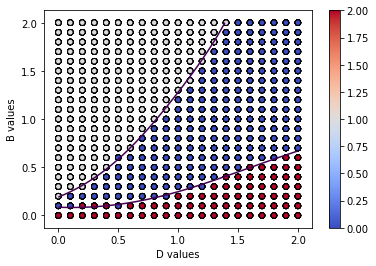

In [8]:
import matplotlib.pyplot as plt

print(Z_0vs1.shape)
Z_0vs1 = Z_0vs1.reshape(xx.shape)
Z_1vs2 = Z_1vs2.reshape(xx.shape)

fig, ax = plt.subplots()
contours_0vs1 = ax.contour(xx, yy, Z_0vs1, levels=[0], linewidth=4, linestyle='--')
contours_1vs2 = ax.contour(xx, yy, Z_1vs2, levels=[0], linewidth=4, linestyle='--')
"""
Skyrmions are labeled 0 and reside in the middle of the phase diagram.
Ferromagnetic phases are labeled 2 and reside at the top left corner of the diagram.
Spin spirals are labeled 1 and reside at the bottom right corner of the diagram 
"""

points = ax.scatter(DB_coordinates[:, 0], DB_coordinates[:, 1], s=30, c=labels, cmap=plt.cm.coolwarm, edgecolors='k')
fig.colorbar(points, ax=ax)
plt.xlabel('D values')
plt.ylabel('B values')
plt.show()

We have decent boundaries between different phases. The trend is very obvious: at low fields exist spin spirals, which break down into skyrmions phases with increasing fields. At high enough fields, all spin textures collapse and align with the magnetic field and form ferromagnetic phase.